# BreaQ QML Track: Hybrid Quantum-Classical Neural Networks for RetinaMNIST

This hackathon focuses on developing hybrid quantum–classical neural networks for the RetinaMNIST dataset. *The emphasis is on designing interesting hybrid models and on finding meaningful metrics to investigate the advantage of using quantum resources.* You are encouraged to experiment with architecture design, analyze performance, and propose meaningful experiments or metrics that quantify the impact of quantum resources within the model.

To support this process, the notebook presents a complete, ready-to-run pipeline based on PyTorch and PennyLane. The example demonstrates data handling, model construction, training, and evaluation using a hybrid neural network workflow. 

#### Feel free to reuse or adapt the provided implementation in any form. The only mandatory requirements for submissions are the use of PennyLane and PyTorch.

In [5]:
import numpy as np
from PIL import Image
from medmnist import RetinaMNIST
import pennylane as qml
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Tuple

## The Dataset: RetinaMNIST

RetinaMNIST is a compact medical imaging dataset composed of retinal fundus photographs labeled on a 5-point diabetic retinopathy severity scale. Although the task is inherently ordinal regression, it is often treated as a standard multi-class classification problem. Its limited size and low resolution make it well suited for rapid experimentation, benchmarking lightweight models, and evaluating hybrid quantum–classical approaches under realistic small-data constraints.

In the following, you are provided with a class to help you load and preprocess the RetinaMNIST dataset. The class handles downloading the data, applying necessary transformations, and preparing it for training and evaluation. Some of the methods already implemented:
 - `__init__`: Loads train, validation, and test splits into memory and formats images and labels.
 - `select_classes`: Filters all splits to keep only a specified set of class IDs.
 - `select_train_percentage`: Retains only a chosen fraction of the training set, with optional shuffling.
 - `normalize`: Applies either min–max scaling or standardization independently to each split.
 - `to_grayscale`: Converts all images to single-channel grayscale format.
 - `resize`: Resizes images in every split to a specified spatial resolution.

Bellow the `DataHandler` implementations there are also some usage examples.

In [6]:
class DataHandler:
    def __init__(self, download=True, as_rgb=True):
        """
        Loads train/val/test splits simultaneously.
        """
        self.datasets = {}
        self.images = {}
        self.labels = {}

        for split in ["train", "val", "test"]:
            ds = RetinaMNIST(split=split, download=download)
            imgs = ds.imgs  # (N, 28, 28)
            labels = ds.labels.squeeze()

            if imgs.ndim == 3:
                if as_rgb:
                    imgs = np.stack([imgs]*3, axis=-1)   # (N, H, W, 3)
                else:
                    imgs = imgs[..., None]               # (N, H, W, 1)

            self.images[split] = imgs.astype(np.uint8)
            self.labels[split] = labels.astype(int)

        self.active_classes = {
            split: np.unique(self.labels[split]) for split in ["train", "val", "test"]
        }

    def select_classes(self, classes):
        """
        Keep only specific class IDs across train, val, test.
        """
        for split in ["train", "val", "test"]:
            cls_set = set(classes)
            mask = np.array([lbl in cls_set for lbl in self.labels[split]])
            self.images[split] = self.images[split][mask]
            self.labels[split] = self.labels[split][mask]
            self.active_classes[split] = np.array(sorted(classes))

    def select_train_percentage(self, pct, shuffle=True, seed=None):
        """
        Keep only a percentage of the training data, preserving class proportions.
        pct: float in (0,1]
        """
        assert 0 < pct <= 1
        N = len(self.labels["train"])
        n_keep = int(N * pct)

        rng = np.random.default_rng(seed)

        classes, counts = np.unique(self.labels["train"], return_counts=True)
        # desired (float) and initial integer allocation per class
        desired = counts * pct
        per_class = np.floor(desired).astype(int)

        # adjust to match total n_keep by distributing the remaining slots
        remainder = n_keep - per_class.sum()
        if remainder > 0:
            fracs = desired - per_class
            order = np.argsort(-fracs)  # largest fractional parts first
            for i in order[:remainder]:
                per_class[i] += 1
        elif remainder < 0:
            rem = -remainder
            fracs = desired - per_class
            order = np.argsort(fracs)  # smallest fractional parts first
            for i in order:
                if per_class[i] > 0:
                    per_class[i] -= 1
                    rem -= 1
                    if rem == 0:
                        break

        # gather indices per class
        keep_idx_list = []
        for cls, k in zip(classes, per_class):
            cls_idx = np.where(self.labels["train"] == cls)[0].copy()
            if shuffle:
                rng.shuffle(cls_idx)
            if k > 0:
                keep_idx_list.append(cls_idx[:k])

        if keep_idx_list:
            keep_idx = np.concatenate(keep_idx_list)
        else:
            keep_idx = np.array([], dtype=int)

        if shuffle and keep_idx.size:
            rng.shuffle(keep_idx)

        self.images["train"] = self.images["train"][keep_idx]
        self.labels["train"] = self.labels["train"][keep_idx]
        self.active_classes["train"] = np.unique(self.labels["train"])

    def normalize(self, method="minmax"):
        """
        Normalize each split independently.
        """
        for split in ["train", "val", "test"]:
            imgs = self.images[split].astype(np.float32)

            if method == "minmax":
                min_val = imgs.min(axis=(0,1,2), keepdims=True)
                max_val = imgs.max(axis=(0,1,2), keepdims=True)
                imgs = (imgs - min_val) / (max_val - min_val + 1e-7)

            elif method == "standard":
                mean = imgs.mean(axis=(0,1,2), keepdims=True)
                std = imgs.std(axis=(0,1,2), keepdims=True) + 1e-7
                imgs = (imgs - mean) / std

            else:
                raise ValueError("Unknown normalization method.")

            self.images[split] = imgs

    def to_grayscale(self):
        """
        Convert images in all splits to grayscale.
        """
        for split in ["train", "val", "test"]:
            gray_list = []
            for img in self.images[split]:
                pil = Image.fromarray(img).convert("L")
                gray_list.append(np.array(pil))
            gray_arr = np.stack(gray_list, axis=0)
            self.images[split] = gray_arr[..., None]

    def resize(self, size):
        """
        Resize images in all splits to (width, height).
        """
        for split in ["train", "val", "test"]:
            out = []
            for img in self.images[split]:
                if img.shape[-1] == 1:
                    pil = Image.fromarray(img.squeeze(), mode="L")
                else:
                    pil = Image.fromarray(img)

                pil = pil.resize(size, Image.BILINEAR)
                arr = np.array(pil)

                if arr.ndim == 2:
                    arr = arr[..., None]

                out.append(arr)
            self.images[split] = np.stack(out, axis=0)


# ------------- Dataset wrapper -------------
def build_dataloaders_fast(dh, batch_size=128, device='cuda'):
    """
    Pre-convert all images to torch.Tensor once.
    """
    loaders = {}
    for split in ["train", "val", "test"]:
        imgs = torch.from_numpy(dh.images[split]).float()  # (N,H,W,C)
        # HWC -> CHW
        imgs = imgs.permute(0,3,1,2)
        if imgs.max() > 1.0:
            imgs /= 255.0
        labels = torch.from_numpy(dh.labels[split]).long()
        dataset = TensorDataset(imgs, labels)
        shuffle = (split == "train")
        loaders[split] = DataLoader(dataset, batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=4,  # increase if your CPU has cores
                                    pin_memory=True if device=='cuda' else False)
    return loaders


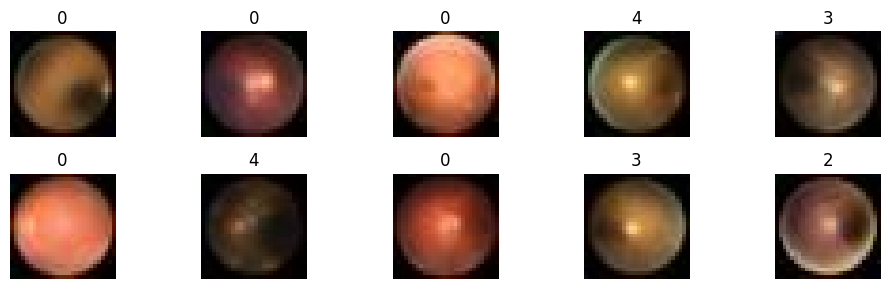

In [7]:
# Raw
import matplotlib.pyplot as plt

dh = DataHandler()

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()


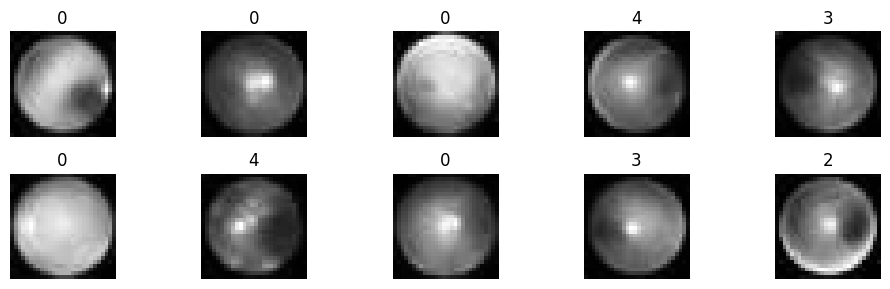

In [8]:
# Grayscale
dh = DataHandler()
dh.to_grayscale()

imgs = dh.images["train"][:10].squeeze(-1)
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

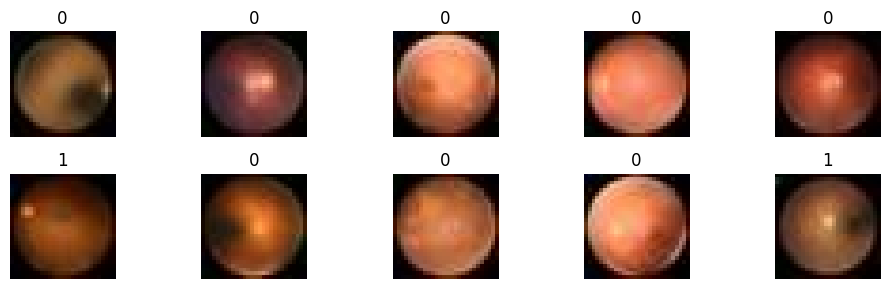

In [9]:
# Classes 0 and 1
dh = DataHandler()
dh.select_classes([0, 1])

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [10]:
# keep 20% of the training set
dh = DataHandler()

print("Before:", len(dh.labels["train"]))

dh.select_train_percentage(0.2, seed=0)

print("After:", len(dh.labels["train"]))

Before: 1080
After: 216


## The model: building HQNNs with PennyLane and PyTorch

The model combines classical deep learning components from PyTorch with a trainable quantum circuit defined using PennyLane. The outer structure is a subclass of `torch.nn.Module`, which is the standard building block for neural networks in PyTorch. Layers are defined in the constructor and organized into `nn.Sequential` blocks, allowing multiple operations such as convolutions, activations, pooling, and linear layers to be stacked into a forward pipeline.

The quantum part is defined as a function decorated with `@qml.qnode`, which tells PennyLane to turn it into a differentiable quantum computation. The shape of the trainable quantum parameters is declared through `weight_shapes`, which ensures compatibility with downstream optimization. The quantum circuit is wrapped with `qml.qnn.TorchLayer`, allowing it to behave like a standard neural network layer inside PyTorch. This means it receives and outputs tensors just like a classical layer and its parameters are tracked by PyTorch’s optimizer. Both quantum and classical weights participate in the same training loop.

The `forward` method defines the flow of data: images pass first through convolutional feature extraction, then through the classifier, and finally through the quantum layer. Gradients propagate automatically across the entire pipeline. PennyLane provides differentiable quantum simulations, while PyTorch’s autograd engine ensures that parameter updates seamlessly include both the neural network weights and the quantum circuit parameters in a single backward pass.

In [11]:

# ------------- PARALLEL QUANTUM MODEL (FIXED DIMENSIONS) -------------

n_layers = 3
n_qubits_block = 2
dev = qml.device("default.qubit", wires=n_qubits_block)

@qml.qnode(dev)
def parallel_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits_block))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits_block))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits_block)]

def build_model(num_classes: int, in_channels: int = 1):
    
    weight_shapes = {"weights": (n_layers, n_qubits_block)}

    class ParallelHybridCNN(nn.Module):
        def __init__(self, in_ch, n_classes):
            super().__init__()
            
            # 1. CNN Feature Extractor
            self.features = nn.Sequential(
                # Bloc 1
                nn.Conv2d(in_ch, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2), # 28x28 -> 14x14
                
                # Bloc 2
                nn.Conv2d(16, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2), # 14x14 -> 7x7
                
                # --- LINIA CARE LIPSEA ---
                # Transformă (32, 7, 7) în (32, 1, 1)
                nn.AdaptiveAvgPool2d(1), 
                
                nn.Flatten() # Acum scoate vector de mărime 32
            )
            
            # 2. Pre-Quantum: Acum Linear(32, 6) este corect
            self.pre_quantum = nn.Sequential(
                nn.Linear(32, 6),
                nn.Tanh() 
            )

            # 3. Straturile Cuantice
            self.q_layer1 = qml.qnn.TorchLayer(parallel_circuit, weight_shapes)
            self.q_layer2 = qml.qnn.TorchLayer(parallel_circuit, weight_shapes)
            self.q_layer3 = qml.qnn.TorchLayer(parallel_circuit, weight_shapes)
            
            # 4. Classifier Final
            self.classifier = nn.Sequential(
                nn.Linear(6, 16),
                nn.ReLU(),
                nn.Linear(16, n_classes)
            )

        def forward(self, x):
            x = self.features(x)
            
            # Calibrare Tanh * Pi
            x_6 = self.pre_quantum(x) * np.pi 
            
            # Split
            x1, x2, x3 = torch.split(x_6, 2, dim=1)
            
            # Parallel Process
            out1 = self.q_layer1(x1)
            out2 = self.q_layer2(x2)
            out3 = self.q_layer3(x3)
            
            # Concat & Classify
            combined = torch.cat([out1, out2, out3], dim=1)
            return self.classifier(combined)

    return ParallelHybridCNN(in_channels, num_classes)

For prototyping it is useful to visualize the quantum circuits. The following cell shows how to plot a quantum circuit using PennyLane's built-in drawing capabilities. The argument `level=None` ensures that all operations are displayed without collapsing them into higher-level gates.

## Training and Evaluation

The training loop follows standard PyTorch conventions. The `train_epoch` function sets the model to training mode, iterates over a data loader, performs forward and backward passes, and updates parameters using the provided optimizer. The loss is computed with a user-defined criterion, and predictions are stored for later metric calculation.

The evaluation function performs the same forward computation in evaluation mode but under `torch.no_grad()`, ensuring that no gradients are tracked and computation is more efficient. No parameter updates occur during evaluation.

In [12]:

# ------------- Training utilities -------------
def train_epoch(model, loader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds_all.append(logits.detach().cpu().numpy())
        labels_all.append(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    # Probabilities for AUC: softmax
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)

    # AUC: handle binary vs multiclass
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc

def evaluate(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds_all.append(logits.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc


## Experiments

The `run_training` function automates the entire workflow of training and evaluating a model. It prepares data loaders, builds the hybrid network, and runs multiple training epochs using the provided optimizer and loss function. After each epoch, validation metrics are computed, and once finished, the model is also tested on the held-out test set. All results, including loss, accuracy, and AUC, are recorded and visualized in plots, providing a clear overview of model performance across the training process.

In [13]:

# ------------- Run full training loop (FIXED) -------------
def run_training(dh: DataHandler,
                 num_epochs: int = 20,
                 batch_size: int = 64,
                 lr: float = 1e-3,
                 resize: Tuple[int,int] = (28,28),
                 grayscale: bool = False,
                 train_pct: float = 1.0,
                 device: str = None):
    
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Started training on ", device, "...")

    if train_pct < 1.0:
        dh.select_train_percentage(train_pct, seed=42)

    loaders = build_dataloaders_fast(dh, batch_size=batch_size, device=device)
    
    num_classes = len(dh.active_classes["train"])
    in_ch = dh.images["train"].shape[-1]

    print(f"Building Parallel Model for {num_classes} classes...")
    model = build_model(num_classes=num_classes, in_channels=in_ch).to(device)
    
    # --- Class Weights ---
    train_labels = dh.labels['train']
    class_counts = np.bincount(train_labels)
    total_samples = len(train_labels)
    
    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Weighted Loss active: {class_weights.cpu().numpy()}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # --- SCHEDULER FIX (Fără verbose=True) ---
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    history = {"train_loss": [], "train_acc": [], "train_auc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}
    
    print("Model built and ready...")

    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        
        # Actualizăm scheduler-ul
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr < old_lr:
            print(f"   >>> Scheduler: Learning Rate reduced to {new_lr:.6f}")

        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f} auc {val_auc:.4f}")

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["train_auc"].append(tr_auc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

    test_loss, test_acc, test_auc = evaluate(model, loaders["test"], device, criterion)
    print(f"\nTest  loss {test_loss:.4f} acc {test_acc:.4f} auc {test_auc:.4f}")

    epochs_range = np.arange(1, num_epochs+1)
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.plot(epochs_range, history["train_loss"], label="train")
    plt.plot(epochs_range, history["val_loss"], label="val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs_range, history["train_acc"], label="train")
    plt.plot(epochs_range, history["val_acc"], label="val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs_range, history["train_auc"], label="train")
    plt.plot(epochs_range, history["val_auc"], label="val")
    plt.title("AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, (test_loss, test_acc, test_auc)

Running 'Smooth & Slow' configuration...
Started training on  cpu ...
Building Parallel Model for 5 classes...
Weighted Loss active: [0.44444445 1.6875     1.0485437  1.113402   3.2727273 ]
Model built and ready...
Epoch 01 | Train loss 1.6120 | Val loss 1.6198 acc 0.0667 auc 0.6074
Epoch 02 | Train loss 1.6021 | Val loss 1.6058 acc 0.3083 auc 0.6223
Epoch 03 | Train loss 1.5861 | Val loss 1.5859 acc 0.3417 auc 0.6595
Epoch 04 | Train loss 1.5757 | Val loss 1.5740 acc 0.3833 auc 0.6918
Epoch 05 | Train loss 1.5685 | Val loss 1.5586 acc 0.3667 auc 0.6864
Epoch 06 | Train loss 1.5588 | Val loss 1.5486 acc 0.3917 auc 0.6977
Epoch 07 | Train loss 1.5499 | Val loss 1.5374 acc 0.3833 auc 0.7094
Epoch 08 | Train loss 1.5460 | Val loss 1.5367 acc 0.3583 auc 0.6999
Epoch 09 | Train loss 1.5434 | Val loss 1.5198 acc 0.3750 auc 0.7163
Epoch 10 | Train loss 1.5336 | Val loss 1.5185 acc 0.4083 auc 0.7121
Epoch 11 | Train loss 1.5273 | Val loss 1.5201 acc 0.4000 auc 0.7160
Epoch 12 | Train loss 1.51

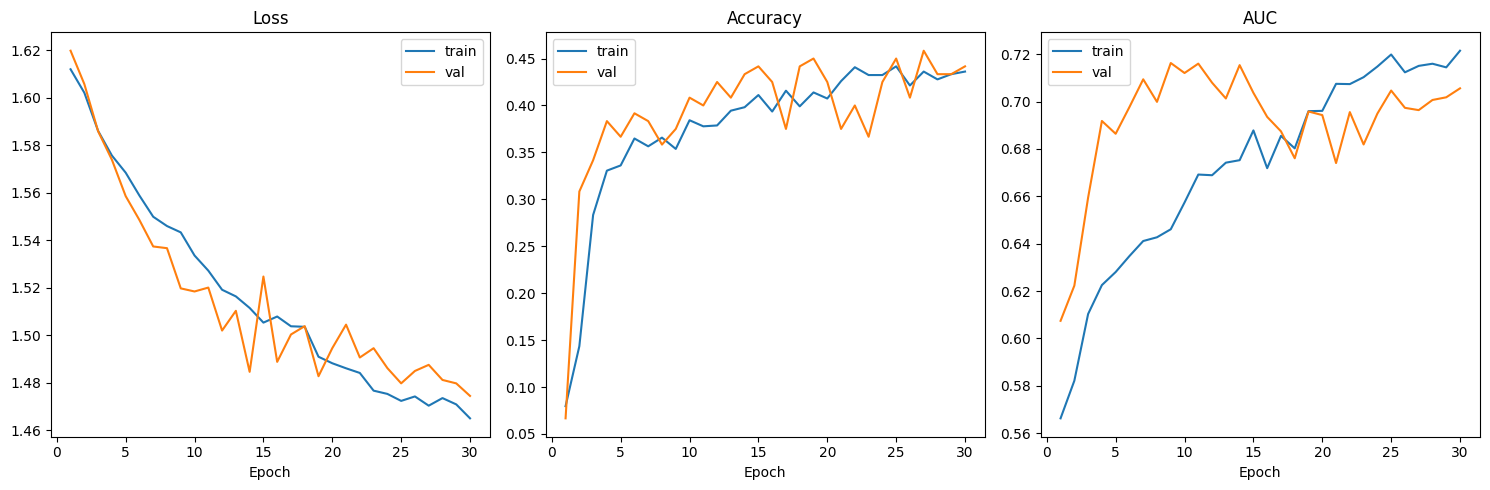

Final test results: (1.5691720676422118, 0.3875, 0.6193452544392216)


In [14]:

# ------------- EXECUTION BLOCK -------------

# 1. Inițializăm datele
# as_rgb=False pentru că vrem 1 singur canal (grayscale) ca să se potrivească cu in_channels=1
dh = DataHandler(download=True, as_rgb=False) # Grayscale
dh.to_grayscale()
dh.normalize('minmax')

print("Running 'Smooth & Slow' configuration...")

# 2. Configurația care repară graficele "urâte"
model, history, test_metrics = run_training(
    dh=dh,
    num_epochs=30,       # Mai multe epoci pentru că învățăm mai lent
    batch_size=32,       # Batch mic = Generalizare mai bună (grafic mai stabil pe Val)
    lr=0.0005,           # Learning Rate MIC (Secretul pentru linii netede)
    resize=(28, 28),     # Dimensiunea nativă (nu distorsionăm imaginea)
    grayscale=True,
    train_pct=1.0,       # Folosim toate datele
    device=None          # Auto-detect (cuda/cpu)
)

print("Final test results:", test_metrics)

.






## Model saver 


In [17]:
checkpoint_path = "Saved_models/Parallel_quantum.pth"
history_path = "Saved_models/Parallel_quantum.json"
import json

torch.save(model.state_dict(), checkpoint_path)
with open(history_path, "w", encoding="utf-8") as fp:
    json.dump(history, fp)
print(f"Saved weights to {checkpoint_path} and history to {history_path}.")
metrics_dict = {
    "test_loss": test_metrics[0],
    "test_acc": test_metrics[1],
    "test_auc": test_metrics[2]
}

# Save to a separate JSON file
with open("Saved_models/Parallel_quantum_testset.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)


Saved weights to Saved_models/Parallel_quantum.pth and history to Saved_models/Parallel_quantum.json.


In [16]:
input = None
output = None